# Fine Tuning Vision Transfomer models for Competition

***What is fine tuning?***

When we face a task where there is a limited dataset, fine tuning based on other large models might be beneficial.There are few major benefits for fine tuning models:

1. Small dataset is not sufficient to train large models which might have thousands or even millions of parameters.

2. Pretrained vision transformers have seen a diverse range of images during their initial training, which helps them learn generic features that are applicable to various visual tasks. Its generic knowledge will be helpful in your specific image classification task. 
(This point will be discussed later...)

3. Training a large model from scratch requires a great amount of computation power which individual developer might not be able to access. By fine-tuning a pretrained vision transformer, you have the potential to achieve state-of-the-art or competitive performance on your task.

***Tips for fine tuning***

1. New dataset is small and similar to original dataset. Since the data is small, it is not a good idea to fine-tune the ConvNet due to overfitting concerns. Since the data is similar to the original data, we expect higher-level features in the ConvNet to be relevant to this dataset as well. Hence, the best idea might be to train a linear classifier on the CNN codes.

2. New dataset is large and similar to the original dataset. Since we have more data, we can have more confidence that we won’t overfit if we were to try to fine-tune through the full network.

3. New dataset is small but very different from the original dataset. Since the data is small, it is likely best to only train a linear classifier. Since the dataset is very different, it might not be best to train the classifier form the top of the network, which contains more dataset-specific features. Instead, it might work better to train the SVM classifier from activations somewhere earlier in the network.

4. New dataset is large and very different from the original dataset. Since the dataset is very large, we may expect that we can afford to train a ConvNet from scratch. However, in practice it is very often still beneficial to initialize with weights from a pretrained model. In this case, we would have enough data and confidence to fine-tune through the entire network.



## Competition:

Let's fine tune a vision transforme for a actual competition: https://zindi.africa/competitions/cgiar-crop-damage-classification-challenge


Necessary files are stored at: https://github.com/Ng-Cho-Yin/CGIAR-Crop-Damage-Classification-Challenge-Files/tree/main


In [28]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

directory = '/kaggle/input/crop-image/images'
widths = []
heights = []
total_files = len([filename for filename in os.listdir(directory)
                  if filename.endswith(".jpg") or filename.endswith(".png")])
for filename in tqdm(os.listdir(directory), total=total_files, desc="Processing images"):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        filepath = os.path.join(directory, filename)
        img = Image.open(filepath)
        width, height = img.size
        widths.append(width)
        heights.append(height)

In [29]:
# Plot the distribution of image resolutions
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(widths, bins=30, color='b')
ax[0].set_xlabel('Width')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Distribution of Image Widths')
ax[1].hist(heights, bins=30, color='r')
ax[1].set_xlabel('Height')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Distribution of Image Heights')
plt.tight_layout()
plt.show()

Mode of dataset ~ 500(width,height)

That's why I choose to use (512,512) as training image size

## Loading a pretrained model:

There are many models available on TIMM,library for state-of-the-art image classification models from Pytorch.

In [30]:
!pip install timm
import timm

***Highlights:***

Custom Image Size: (512,512)

The default image size for training for "vit_base_patch16_224" is (224,224).It is beneficial to finetune the model with large image size (high resolution).So we have to pass in img_size=(512, 512) to modify the expected image size for training.

In [31]:
default_model = timm.create_model('vit_base_patch16_224', pretrained=True)
print("default positional encoding of vit")
print(default_model.patch_embed.grid_size)

model = timm.create_model('vit_base_patch16_224', img_size=(512, 512), pretrained=True)
print("modified positional encoding of vit")
print(model.patch_embed.grid_size)

default positional encoding of vit
(14, 14)
modified positional encoding of vit
(32, 32)


*hints: The positional encoding of the Vit is changed*

## Pre-processing data:

***Importing basic libraries for training***

In [32]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.model_selection import StratifiedShuffleSplit
from torch import nn, optim
from timm.loss import LabelSmoothingCrossEntropy
from torchvision.transforms import ToTensor, Resize
from PIL import Image
import random
import cv2

***Loading datasets***

In [33]:
crop_dataset = pd.read_csv("/kaggle/input/crop-data-train-csv/Train.csv")
test_df = pd.read_csv("/kaggle/input/crop-test-csv/Test.csv")
test_df['WD'] = np.nan
test_df['G'] = np.nan
test_df['DR'] = np.nan
test_df['ND'] = np.nan
test_df['other'] = np.nan

***This is the dataset used for training and validating performance of our model***

In [34]:
crop_dataset

,ID,damage,filename
0,ID_UBHORS,WD,d036341be8d6cd59851cb80bcc9a70cc9fbdba30.jpg
1,ID_9DSOLZ,G,9ea16180c50d0cd539897eefbfe585314e50a56b.jpg
2,ID_JHLM0G,G,b6b564844041bc68774a553eaf43d61654657dd9.jpg
3,ID_ATREIJ,DR,62262859f0cd411aaf484082ed3ef0b625bc452a.jpg
4,ID_L2GAD6,G,03b6e2a8ace7cb611eccba289f3c83d9bd497584.jpg
...,...,...,...
26063,ID_SQQ5T2,DR,dd3f7966864f9466b9d57714983c3259c905f1e7.jpg
26064,ID_T5WAM0,G,cab5d10958f28b17d887748f9cd1d35796db0902.jpg
26065,ID_9W6G7O,G,7feedaf352fe16b24454fc4ee283bb85c3f17ccb.jpg
26066,ID_YQ07UW,G,f295f949ece1867921363df9e4c3d17e8d7fc22f.jpg


***This is the targeted dataset which will store the predicted result from our model***

In [35]:
test_df

,ID,filename,WD,G,DR,ND,other
0,ID_QW9GQM,03428805a0d7d269b422dbfafb3f86cb394a0491.jpg,NaN,NaN,NaN,NaN,NaN
1,ID_G9VPQ9,5dcf4f5d82708496ad7c3227ccbc8af5058aa227.jpg,NaN,NaN,NaN,NaN,NaN
2,ID_QIMIEM,4e835aa40e4aafa24db13cba4182094eb9e5eb79.jpg,NaN,NaN,NaN,NaN,NaN
3,ID_TSINUQ,1e0dbb8669385be73a480ce108d12bdc4354f120.jpg,NaN,NaN,NaN,NaN,NaN
4,ID_I7OOHH,3d05e31502f9f00ce25770666c73af5f323a8b3a.jpg,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
8658,ID_JZJP19,8b58a11023be5530af0fd1800b2c53c36f50605f.jpg,NaN,NaN,NaN,NaN,NaN
8659,ID_137G9B,2d3c4c70b893bf32c33919e5c1703b816b95a6d9.jpg,NaN,NaN,NaN,NaN,NaN
8660,ID_F7R60Y,49d9c6cadb9a424fc31aff1d6732023235e6ceb7.jpg,NaN,NaN,NaN,NaN,NaN
8661,ID_76JGLU,618f93ddbb02e2abf4b97ac458b2c2e727c2e0a4.jpg,NaN,NaN,NaN,NaN,NaN


***Collect the unique types of damaged crop,then create two dictionaries that record their damage type and index respectively.***

In [36]:
damage_type = crop_dataset['damage'].unique()
damage2idx = dict((damage,idx) for idx,damage in enumerate(damage_type))
idx2damage = dict((idx,damage) for idx,damage in enumerate(damage_type))
crop_dataset['label_idx'] = [damage2idx[i] for i in crop_dataset.damage]
crop_dataset.head()

,ID,damage,filename,label_idx
0,ID_UBHORS,WD,d036341be8d6cd59851cb80bcc9a70cc9fbdba30.jpg,0
1,ID_9DSOLZ,G,9ea16180c50d0cd539897eefbfe585314e50a56b.jpg,1
2,ID_JHLM0G,G,b6b564844041bc68774a553eaf43d61654657dd9.jpg,1
3,ID_ATREIJ,DR,62262859f0cd411aaf484082ed3ef0b625bc452a.jpg,2
4,ID_L2GAD6,G,03b6e2a8ace7cb611eccba289f3c83d9bd497584.jpg,1


***Define a custom dataset class***

In [37]:
class CropDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.label = csv_file
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.label.filename[idx])
        image = Image.open(img_name)
        label_type = torch.tensor(self.label.label_idx[idx])
        filename = self.label.filename[idx]

        if self.transform:
            image = self.transform(image)

        return image,label_type,filename

    
class Test_CropDataset(Dataset):
    def __init__(self,csv_file,root_dir,transform=None):
        self.test = csv_file
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.test)
    
    def __getitem__(self,idx):
        img_name = os.path.join(self.root_dir, self.test.filename[idx])
        image = Image.open(img_name)
        image_id = self.test.ID[idx]
        if self.transform:
            image = self.transform(image)

        return image,image_id

***Dataset transformation and augmentation functions***

Normalization: Histogram Equalization

In [38]:
def histogram_equalization(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    l_eq = cv2.equalizeHist(l)
    lab_eq = cv2.merge((l_eq, a, b))
    img_eq = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2RGB)
    
    return img_eq

def compare_img_normalize(filename):
    hist_eq_transform = transforms.Compose([
    transforms.Lambda(lambda img: histogram_equalization(np.array(img))),
    transforms.ToPILImage()])
    
    img = mpimg.imread("/kaggle/input/crop-image/images/" + filename)
    img_eq = hist_eq_transform(img)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(img)
    ax1.set_title("Original Image")
    ax2.imshow(img_eq)
    ax2.set_title("Transformed Image")
    plt.show()

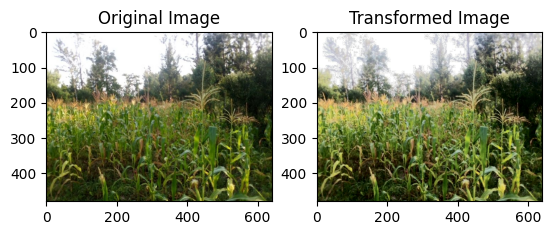

In [39]:
directory = '/kaggle/input/crop-image/images'
rand = random.randint(0, len(os.listdir(directory)))
compare_img_normalize(os.listdir(directory)[rand])

In [40]:
IMG_SIZE = 512 # Since we have modified the default image size for training,so we will pass in image with size (512,512)


train_transforms = transforms.Compose([
    transforms.Lambda(lambda img: histogram_equalization(np.array(img))),
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),

])# train dataset: transformation + augmentation

val_transforms = transforms.Compose([
    transforms.Lambda(lambda img: histogram_equalization(np.array(img))),
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),

])# validation dataset: transformation only

test_transforms = transforms.Compose([
    transforms.Lambda(lambda img: histogram_equalization(np.array(img))),
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),

])# test dataset: transformation only


In [41]:
BATCH_SIZE= 256
cuda=torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

***Define train and valid set (10% for validation)***

In [42]:
dataset_names = ['train', 'valid']
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
train_split_idx, val_split_idx = next(iter(stratified_split.split(crop_dataset.filename, crop_dataset.damage)))
train_df = crop_dataset.iloc[train_split_idx].reset_index()
val_df = crop_dataset.iloc[val_split_idx].reset_index()
print(len(train_df))
print(len(val_df))

23461
2607


***Sets up training,validation and test datasets***

In [43]:
train_dataset = CropDataset(train_df,"/kaggle/input/crop-image/images",transform=train_transforms)
val_dataset = CropDataset(val_df,"/kaggle/input/crop-image/images",transform=val_transforms)
test_dataset = Test_CropDataset(test_df,"/kaggle/input/crop-image/images",transform=test_transforms)
image_dataset = {'train':train_dataset, 'valid':val_dataset}
image_dataloader = {x:DataLoader(image_dataset[x],batch_size=BATCH_SIZE,shuffle=True,num_workers=0) for x in dataset_names}
test_dataloader = DataLoader(test_dataset,batch_size=1,shuffle=True,num_workers=0)
dataset_sizes = {x:len(image_dataset[x]) for x in dataset_names}

***Show original and augumented images***

In [44]:
def compare_img(filename,image_tensor):
    origin_img = mpimg.imread("/kaggle/input/crop-image/images/" + filename)
    image_tensor = image_tensor.permute(1, 2 ,0)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(origin_img)
    ax1.set_title("Original Image")
    ax2.imshow(image_tensor)
    ax2.set_title("Transformed Image")
    plt.show()

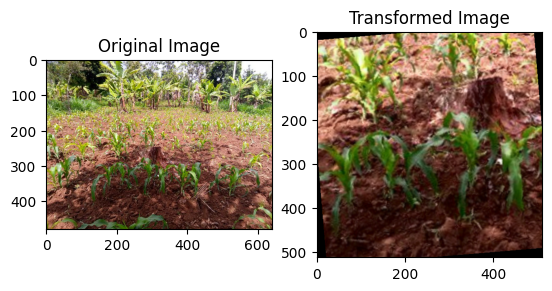

In [45]:
rand = random.randint(0, len(train_dataset))
compare_img(train_dataset[rand][2],train_dataset[rand][0])

## Define model and training:

***Original model***

In [46]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

***Freeze parameters for the entire model so that the model still restore the ability to capture generic features from images***

In [47]:
for param in model.parameters():
    param.requires_grad = False

***Modify the output of the model from classifying 1000 images to classifying 5 damage types***

In [48]:
n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(crop_dataset['damage'].unique()))
)

print(model.head)

Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=5, bias=True)
)


***Print the modified model***

In [49]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

***Define Loss function, Optimizer and Learning rate scheduler***

In [50]:
model= model.to(device) 
criterion = LabelSmoothingCrossEntropy()
optimizer = torch.optim.Adam([
    {'params':model.head.parameters()}], lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

***Define train,valid and test loop***

In [55]:
from tqdm import tqdm

def train(model, device, train_loader, epoch):
    model.train()
    train_loss = 0
    pbar = tqdm(train_loader, total=len(train_loader))
    for batch_idx, data in enumerate(pbar):
        x, y, path = data
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pbar.set_description(f'Train Epoch: {epoch} Loss: {loss.item():.6f}')
    exp_lr_scheduler.step()
    train_loss /= len(train_loader)
    print('Train Epoch: {}\t Average Loss: {:.6f}'.format(epoch, train_loss))


def valid(model, device, val_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            x, y, path = data
            x = x.to(device)
            y = y.to(device)
            y_hat = model(x)
            test_loss += criterion(y_hat, y).item()
            pred = y_hat.max(1, keepdim=True)[1]
            prob = nn.functional.softmax(y_hat, dim=1)
            
            correct += pred.eq(y.view_as(pred)).sum().item()
    test_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(val_loader.dataset), accuracy))

    

def test(model, device, test_dataloader, test_df):
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(tqdm(test_dataloader)):
            x, image_id = data
            x = x.to(device)
            y_hat = model(x)
            pred = y_hat.max(1, keepdim=True)[1]
            prob = nn.functional.softmax(y_hat, dim=1)
            prob = prob.tolist()[0]
            image_id = image_id[0]
            test_df.loc[test_df['ID'] == str(image_id), 'WD'] = prob[0]
            test_df.loc[test_df['ID'] == str(image_id), 'G'] = prob[1]
            test_df.loc[test_df['ID'] == str(image_id), 'DR'] = prob[2]
            test_df.loc[test_df['ID'] == str(image_id), 'ND'] = prob[3]
            test_df.loc[test_df['ID'] == str(image_id), 'other'] = prob[4]

***Load checkpoint if checkpoint exists for continuous training***

In [52]:
path = "..."

if os.path.exists(path):
    print("trained model exists")
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']

else:
    print("File does not exist.")

File does not exist.


### Training Begins...

In [ ]:
for epoch in range(1, 50):
    train(model=model, device=device, train_loader=image_dataloader["train"], epoch=epoch)
    valid(model=model, device=device, val_loader=image_dataloader["valid"])
    if epoch % 5 == 0:
        EPOCH = epoch
        PATH = "/kaggle/working/model.pt"
        torch.save({
                'epoch': EPOCH,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, PATH)

Train Epoch: 1 Loss: 1.006623: 100%|██████████| 92/92 [28:44<00:00, 18.74s/it]
Train Epoch: 1	 Average Loss: 1.080544

Test set: Average loss: 0.0042, Accuracy: 1722/2607 (66%)

Train Epoch: 2 Loss: 0.985042: 100%|██████████| 92/92 [25:56<00:00, 16.92s/it]
Train Epoch: 2	 Average Loss: 1.014157

Test set: Average loss: 0.0042, Accuracy: 1714/2607 (66%)

Train Epoch: 3 Loss: 1.020095: 100%|██████████| 92/92 [25:52<00:00, 16.87s/it]
Train Epoch: 3	 Average Loss: 1.001956

Test set: Average loss: 0.0041, Accuracy: 1777/2607 (68%)

Train Epoch: 4 Loss: 0.981239: 100%|██████████| 92/92 [25:57<00:00, 16.93s/it]
Train Epoch: 4	 Average Loss: 0.994647

Test set: Average loss: 0.0040, Accuracy: 1766/2607 (68%)

Train Epoch: 5 Loss: 0.957280: 100%|██████████| 92/92 [26:01<00:00, 16.97s/it]
Train Epoch: 5	 Average Loss: 0.987179

Test set: Average loss: 0.0040, Accuracy: 1786/2607 (69%)

Train Epoch: 6 Loss: 0.928576: 100%|██████████| 92/92 [25:56<00:00, 16.91s/it]
Train Epoch: 6	 Average Loss: 0.980558

Test set: Average loss: 0.0040, Accuracy: 1795/2607 (69%)

Train Epoch: 7 Loss: 1.016123: 100%|██████████| 92/92 [26:00<00:00, 16.97s/it]
Train Epoch: 7	 Average Loss: 0.976800

Test set: Average loss: 0.0040, Accuracy: 1810/2607 (69%)

Train Epoch: 8 Loss: 0.904924: 100%|██████████| 92/92 [25:55<00:00, 16.90s/it]
Train Epoch: 8	 Average Loss: 0.973826

Test set: Average loss: 0.0041, Accuracy: 1734/2607 (67%)

Train Epoch: 9 Loss: 1.015487: 100%|██████████| 92/92 [25:49<00:00, 16.84s/it]
Train Epoch: 9	 Average Loss: 0.972634

Test set: Average loss: 0.0039, Accuracy: 1817/2607 (70%)

Train Epoch: 10 Loss: 0.964507: 100%|██████████| 92/92 [25:46<00:00, 16.81s/it]
Train Epoch: 10	 Average Loss: 0.969617

Test set: Average loss: 0.0040, Accuracy: 1793/2607 (69%)

Train Epoch: 11 Loss: 0.904343: 100%|██████████| 92/92 [25:44<00:00, 16.79s/it]
Train Epoch: 11	 Average Loss: 0.966342

Test set: Average loss: 0.0039, Accuracy: 1810/2607 (69%)

Train Epoch: 12 Loss: 0.976733: 100%|██████████| 92/92 [25:59<00:00, 16.95s/it]
Train Epoch: 12	 Average Loss: 0.961925

Test set: Average loss: 0.0039, Accuracy: 1804/2607 (69%)

Train Epoch: 13 Loss: 0.961130: 100%|██████████| 92/92 [26:02<00:00, 16.98s/it]
Train Epoch: 13	 Average Loss: 0.958614

Test set: Average loss: 0.0039, Accuracy: 1823/2607 (70%)

Train Epoch: 14 Loss: 1.043266: 100%|██████████| 92/92 [25:41<00:00, 16.75s/it]
Train Epoch: 14	 Average Loss: 0.955198

Test set: Average loss: 0.0039, Accuracy: 1835/2607 (70%)

Train Epoch: 15 Loss: 0.945786: 100%|██████████| 92/92 [25:36<00:00, 16.70s/it]
Train Epoch: 15	 Average Loss: 0.959799

Test set: Average loss: 0.0039, Accuracy: 1834/2607 (70%)

Train Epoch: 16 Loss: 0.965347: 100%|██████████| 92/92 [25:49<00:00, 16.85s/it]
Train Epoch: 16	 Average Loss: 0.953419

Test set: Average loss: 0.0039, Accuracy: 1821/2607 (70%)

Train Epoch: 17 Loss: 0.963941: 100%|██████████| 92/92 [25:50<00:00, 16.86s/it]
Train Epoch: 17	 Average Loss: 0.951427

Test set: Average loss: 0.0039, Accuracy: 1814/2607 (70%)

Train Epoch: 18 Loss: 0.854819: 100%|██████████| 92/92 [25:57<00:00, 16.93s/it]
Train Epoch: 18	 Average Loss: 0.942551

Test set: Average loss: 0.0039, Accuracy: 1826/2607 (70%)

Train Epoch: 19 Loss: 0.913738: 100%|██████████| 92/92 [25:56<00:00, 16.92s/it]
Train Epoch: 19	 Average Loss: 0.942527

Test set: Average loss: 0.0039, Accuracy: 1858/2607 (71%)

Train Epoch: 20 Loss: 0.887324: 100%|██████████| 92/92 [26:04<00:00, 17.00s/it]
Train Epoch: 20	 Average Loss: 0.941557



### ......... (Training loop continues)


## Output submission for test dataset:

In [ ]:
test(model=model, device=device, test_dataloader=test_dataloader,test_df=test_df)
test_df = test_df.drop('filename',axis=1)
test_df.to_csv('submission_df.csv', index=False)
test_df

100%|██████████| 8663/8663 [12:25<00:00, 11.61it/s]